In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.pipeline import Pipeline
from itertools import combinations
%matplotlib inline

# How Much is Your Car Worth?

Data about the retail price of 2005 General Motors cars can be found in `car_data.csv`.

The columns are:

1. Price: suggested retail price of the used 2005 GM car in excellent condition.
2. Mileage: number of miles the car has been driven
3. Make: manufacturer of the car such as Saturn, Pontiac, and Chevrolet
4. Model: specific models for each car manufacturer such as Ion, Vibe, Cavalier
5. Trim (of car): specific type of car model such as SE Sedan 4D, Quad Coupe 2D          
6. Type: body type such as sedan, coupe, etc.      
7. Cylinder: number of cylinders in the engine        
8. Liter: a more specific measure of engine size     
9. Doors: number of doors           
10. Cruise: indicator variable representing whether the car has cruise control (1 = cruise)
11. Sound: indicator variable representing whether the car has upgraded speakers (1 = upgraded)
12. Leather: indicator variable representing whether the car has leather seats (1 = leather)

## Tasks, Part 1

1. Find the linear regression equation for mileage vs price.
2. Chart the original data and the equation on the chart.
3. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)

## Tasks, Part 2

1. Use mileage, cylinders, liters, doors, cruise, sound, and leather to find the linear regression equation.
2. Find the equation's $R^2$ score (use the `.score` method) to determine whether the
equation is a good fit for this data. (0.8 and greater is considered a strong correlation.)
3. Find the combination of the factors that is the best predictor for price.

## Tasks, Hard Mode

1. Research dummy variables in scikit-learn to see how to use the make, model, and body type.
2. Find the best combination of factors to predict price.

In [2]:
df = pd.read_csv("car_data.csv")

In [3]:
df.head()

,Price,Mileage,Make,Model,Trim,Type,Cylinder,Liter,Doors,Cruise,Sound,Leather
0,17314.103129,8221,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,1
1,17542.036083,9135,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
2,16218.847862,13196,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,1,0
3,16336.913140,16342,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,0
4,16339.170324,19832,Buick,Century,Sedan 4D,Sedan,6,3.1,4,1,0,1


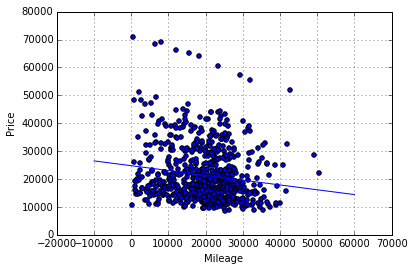

In [4]:
mile_price = linear_model.LinearRegression()
mile_price.fit(df.Mileage.reshape(-1,1), df.Price)
mpfn = lambda x: mile_price.predict(x)[0]

df.plot(kind='scatter', x='Mileage', y='Price')
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [mpfn(x) for x in xs])

In [5]:
print('r**2 = ', round(mile_price.score(df.Mileage.reshape(-1, 1), df.Price), 3), ', Terrible.')

r**2 =  0.02 , Terrible.


In [6]:
columns = ['Mileage', 'Cylinder', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather']

combos = []
for idx in range(1, len(columns)):
    combos.extend(combinations(columns, idx))

scores = {}
for combo in combos:
    regr = linear_model.LinearRegression()
    regr.fit(df[list(combo)].as_matrix(), df.Price.as_matrix().T)
    
    scores[tuple(combo)] = regr.score(df[list(combo)].as_matrix(), df.Price.as_matrix().T)
    
best = max(scores.items(), key=lambda x: x[1])
print(best[0], ' ', best[1])

('Mileage', 'Cylinder', 'Doors', 'Cruise', 'Sound', 'Leather')   0.445690921059


not a great correlation

# Changing categorical data to integer data

In [7]:
makes = {item for item in df.Make}
models = {item for item in df.Model}
types = {item for item in df.Type}
trims = {item for item in df.Trim}
makes = list(makes)
models = list(models)
types = list(types)
trims = list(trims)
df.Make = df.Make.apply(lambda x: makes.index(x))
df.Model = df.Model.apply(lambda x: models.index(x))
df.Type = df.Type.apply(lambda x: types.index(x))
df.Trim = df.Trim.apply(lambda x: trims.index(x))

In [8]:
cols = list(df.columns[:])
cols.remove('Price')
combos = []
for idx in range(1, len(cols)):
    combos.extend(combinations(cols, idx))

In [18]:
cats = ['Make', 'Model', 'Trim', 'Type']
values = {}
for combo in combos:
    categories = [item for item in cats if item in combo]
    mat = df[list(combo)].as_matrix()
    
    if categories:
        categories = list(map(lambda x: list(combo).index(x), categories))

        OH = preprocessing.OneHotEncoder(categorical_features=categories)
        regr = linear_model.LinearRegression()
        pipe = Pipeline([('onehot', OH),('lin', regr)])
        pipe.fit(mat, df.Price.as_matrix().T)
        values[tuple(combo)] = pipe.score(mat, df.Price.as_matrix().T)
    else:
        regr = linear_model.LinearRegression()
        regr.fit(mat, df.Price.as_matrix().T)
        values[tuple(combo)] = regr.score(mat, df.Price.as_matrix().T)

In [19]:
best = max(values.items(), key=lambda x: x[1])
print('Best match: ', best[0], ' with r**2 = ', round(best[1], 3))

Best match:  ('Mileage', 'Model', 'Trim', 'Liter', 'Doors', 'Cruise', 'Sound', 'Leather')  with r**2 =  0.992


# Everything but the cylinders